<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# Classification error metrics

In this notebook we will be applying classification metrics to evaluate the performance of a classifier model.  We are going to use a dataset which comes from a study done to try to use sonar signals to differentiate between a mine (simulated using a metal cylinder) and a rock.  We have 208 observations (sonar readings), and each observation has 60 features (energy in a particular frequency band summed over a set period of time) and a target value (rock 'R' or mine 'M').  Our goal will be to build a model which can use the sonar readings to predict whether the object is a mine or rock.

Details on the dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks))

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Download the sonar data
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/sonar.csv'
data = pd.read_csv(url, header=None)
print(data.shape)
data.head()

(208, 61)


,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


We are going to make one change in our dataset, which is the labeling of the target.  Since our goal is to correctly identify mines (we care much more about correctly identifying the mines than the rocks), rather than using 'R' and 'M' as the labels we will use '0' (rock) and '1' (mine).

In [3]:
# Covert the target labels to 0s and 1s
data.iloc[:,60] = np.where(data.iloc[:,60]=='M',1,0)

# Create a feature matrix using the first 60 columns as the features
X = data.iloc[:,:60]

# Create a target vector from the last column
y = data.iloc[:,60]

# Let's set aside a test set and use the remainder for training and cross-validation
X_train,X_test,y_train,y_test = train_test_split(X, y, random_state=0,test_size=0.4)

We will use a MLP (simple neural network) model and evaluate its performance using various classification metrics.  Do not worry about understanding what an MLP is or how it works right now - we will get to that in a later session.  For now, you can treat it as a black box classification model.

In [4]:
# Set up the MLP classifier model
model = MLPClassifier(hidden_layer_sizes=(100,50),activation='relu',
                      solver='sgd',learning_rate_init=0.01,max_iter=1000)

In [5]:
# Train the model on the training data
model.fit(X_train,y_train)

# Get the predictions for the test data to compute error metrics
test_preds = model.predict(X_test)

Now we are ready to compute our error metrics.  Let's start by displaying the confusion matrix

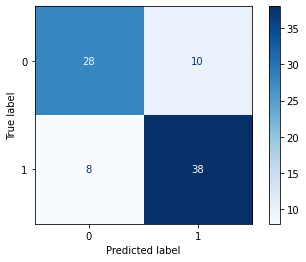

In [7]:
# Display the confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, X_test, y_test,cmap=plt.cm.Blues,normalize=None)
plt.show()

### Question: what is more important to us, minimizing false positives or false negatives?

Answer: minimizing false negatives. A false positive means we thought a rock was a mine.  A false negative means we thought a mine was a rock - as you might image, this mistake could end very badly for us!

### Therefore, which metric should we pay more attention to - precision or recall?

Answer: Recall.  We want to ensure we are correctly identifying all of the positive class (mine), which is what recall measures.

Now that we have our confusion matrix, let's compute the accuracy, recall and precision.

In [10]:
# Compute the accuracy, precision and recall for the target class ('1')
from sklearn.metrics import accuracy_score,recall_score,precision_score
print('Accuracy: {:.3f}'.format(accuracy_score(y_test,test_preds)))
print('Recall: {:.3f}'.format(recall_score(y_test,test_preds)))
print('Precision: {:.3f}'.format(precision_score(y_test,test_preds)))

Accuracy: 0.786
Recall: 0.826
Precision: 0.792


In [12]:
# Alternatively, we can simply use sklearn's classification_report to display metrics for each class and overall
from sklearn.metrics import classification_report
print(classification_report(y_test,test_preds))

              precision    recall  f1-score   support

           0       0.78      0.74      0.76        38
           1       0.79      0.83      0.81        46

    accuracy                           0.79        84
   macro avg       0.78      0.78      0.78        84
weighted avg       0.79      0.79      0.79        84



### Adjusting threshold values
Now let's change the threshold value for classification as a mine ('1') and see how it impacts our metrics

In [14]:
# Get the predicted probabilities of class "1"
test_preds_prob = model.predict_proba(X_test)
test_preds_prob1 = test_preds_prob[:,1] # Probabilities for class 1 only

# Use a threshold=0.1 to get discreet predictions from the probabilities
thresh = 0.1
test_preds_thresh = (test_preds_prob1>=thresh).astype(int)

# Calculate metrics
print('With threshold = 0.1:')
print('Accuracy: {:.3f}'.format(accuracy_score(y_test,test_preds_thresh)))
print('Recall: {:.3f}'.format(recall_score(y_test,test_preds_thresh)))
print('Precision: {:.3f}'.format(precision_score(y_test,test_preds_thresh)))

With threshold = 0.1:
Accuracy: 0.774
Recall: 0.913
Precision: 0.737


In [15]:
# Use a threshold=0.9 to get discreet predictions from the probabilities
thresh = 0.9
test_preds_thresh = (test_preds_prob1>=thresh).astype(int)

# Calculate metrics
print('With threshold = 0.9:')
print('Accuracy: {:.3f}'.format(accuracy_score(y_test,test_preds_thresh)))
print('Recall: {:.3f}'.format(recall_score(y_test,test_preds_thresh)))
print('Precision: {:.3f}'.format(precision_score(y_test,test_preds_thresh)))

With threshold = 0.9:
Accuracy: 0.786
Recall: 0.717
Precision: 0.868


### ROC Curve
Plotting the Receiver Operating Characteristic curve enables us to see how robust the model is at different threshold levels.  We can calculate the area under the curve (the AUROC) as a metric for the quality of the model.

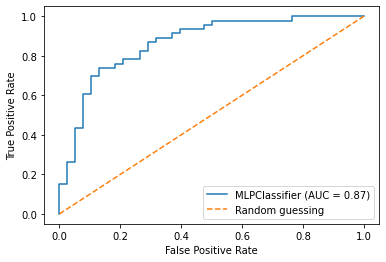

In [20]:
# Plot the ROC curve
from sklearn.metrics import plot_roc_curve
plot_roc_curve(model,X_test,y_test)
# Add a line to show the curve for random guessing
plt.plot([0,1],[0,1],linestyle='--',label='Random guessing')
plt.legend()
plt.show()

We can see above that our classifier model is fairly good, relative to random guessing.  The area under the ROC curve (AUC) is 0.87, which is quite high.

### Precision-Recall Curve
Finally, let's plot the Precision-Recall curve for our model.  The PR curve is particularly useful relative to the ROC curve when we have high class imbalance in our data.  In this case our data is fairly well mixed between the two classes, so either curve would be useful to evaluate our model.

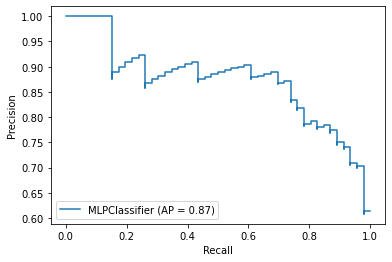

In [21]:
# Plot the precision-recall curve
from sklearn.metrics import plot_precision_recall_curve
plot_precision_recall_curve(model,X_test,y_test)
plt.show()

We can see that the area under the PR curve is 0.87, which is quite high (it ranges from 0 to 1, with 1 indicating a perfect model).  Using the area under the ROC or PR curve is generally a more robust method of evaluating the quality of a model relative to selecting an individual metric (e.g. accuracy or recall).